In [1]:
import os
import pydicom
from tqdm import tqdm 
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchsummary import summary
import segmentation_models_pytorch as smp
import gc
import random
from ultralytics import YOLO
import wandb

/home/abk171/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [7]:
restructured_root = 'data_yolo'
image_dir = os.path.join(restructured_root, 'images')
image_train_dir = os.path.join(image_dir, 'train')
image_val_dir = os.path.join(image_dir, 'val')
image_test_dir = os.path.join(image_dir, 'test')
label_dir = os.path.join(restructured_root, 'labels')
label_train_dir = os.path.join(label_dir, 'train')
label_val_dir = os.path.join(label_dir, 'val')

In [8]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [9]:
def load_mask(mask_path):
    mask = sitk.ReadImage(mask_path)
    return sitk.GetArrayFromImage(mask)[0][: 450, 200: 1300]

def load_dicom(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    return dicom_data.pixel_array[: 450, 200: 1300]

In [10]:
model = YOLO("runs/detect/train17/weights/best.pt")
model.eval()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [11]:
train_images = []
train_masks = []
val_images = []
val_masks = []

def fill_arr(img_dir, img_bucket, mask_bucket):
    for jpg_name in tqdm(os.listdir(img_dir)): 
        img_filename = jpg_name.split('.')[0] + '.dcm'
        mask_filename = jpg_name.split('.')[0] + '.nii.gz'
        img = load_dicom(os.path.join(dicom_dir, img_filename))
        mask = load_mask(os.path.join(anno_dir, mask_filename))
        # img_bucket.append(img)
        # mask_bucket.append(mask)
        
        result = model(img, save=False)
        box = result[0].boxes
        # print(box.xyxy.tolist()[0])
        # break
        if len(box.xyxy.tolist())== 0:
            continue
        x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])
        img_bucket.append(img[y1:y2, x1:x2, 0])
        mask_bucket.append(mask[y1:y2, x1:x2])

# def fill_arr(img_dir, img_bucket,filetype='.dcm'):
#     for jpg_name in tqdm(os.listdir(img_dir)):
#         filename = jpg_name.split('.')[0] + filetype
#         img = load_dicom(os.path.join(dicom_dir, filename)) if filetype == '.dcm' else load_mask(os.path.join(anno_dir, filename))
#         img_bucket.append(img)

# fill_arr(image_train_dir, train_images)
# fill_arr(image_val_dir, val_images)
# fill_arr(label_train_dir, train_masks, filetype='.nii.gz')
# fill_arr(image_val_dir, val_masks, filetype='.nii.gz')

fill_arr(image_train_dir, train_images, train_masks)
fill_arr(image_val_dir, val_images, val_masks)

  0%|                              | 0/87 [00:00<?, ?it/s]


0: 480x1120 1 ulnar, 41.0ms
Speed: 7.2ms preprocess, 41.0ms inference, 125.4ms postprocess per image at shape (1, 3, 480, 1120)


  1%|▎                     | 1/87 [00:00<01:06,  1.29it/s]


0: 480x1120 1 ulnar, 7.3ms
Speed: 3.4ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


  2%|▌                     | 2/87 [00:00<00:32,  2.64it/s]


0: 480x1120 (no detections), 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


  5%|█                     | 4/87 [00:01<00:16,  5.03it/s]


0: 480x1120 1 ulnar, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


  7%|█▌                    | 6/87 [00:01<00:12,  6.70it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


  9%|██                    | 8/87 [00:01<00:09,  7.97it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 2 ulnars, 7.4ms
Speed: 3.7ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 1120)


 11%|██▍                  | 10/87 [00:01<00:08,  8.72it/s]


0: 480x1120 1 ulnar, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 14%|██▉                  | 12/87 [00:01<00:07,  9.80it/s]


0: 480x1120 (no detections), 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 1120)


 16%|███▍                 | 14/87 [00:02<00:09,  7.66it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 18%|███▊                 | 16/87 [00:02<00:08,  8.64it/s]


0: 480x1120 1 ulnar, 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 3.6ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 21%|████▎                | 18/87 [00:02<00:07,  9.22it/s]


0: 480x1120 1 ulnar, 7.4ms
Speed: 3.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 23%|████▊                | 20/87 [00:02<00:07,  9.25it/s]


0: 480x1120 1 ulnar, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 25%|█████▎               | 22/87 [00:02<00:06,  9.71it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 28%|█████▊               | 24/87 [00:03<00:06, 10.26it/s]


0: 480x1120 1 ulnar, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 30%|██████▎              | 26/87 [00:03<00:05, 10.40it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 32%|██████▊              | 28/87 [00:03<00:05, 11.09it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 34%|███████▏             | 30/87 [00:03<00:05, 11.01it/s]


0: 480x1120 1 ulnar, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 37%|███████▋             | 32/87 [00:03<00:04, 11.44it/s]


0: 480x1120 1 ulnar, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 (no detections), 7.6ms
Speed: 3.4ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 1120)


 39%|████████▏            | 34/87 [00:03<00:04, 11.19it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 41%|████████▋            | 36/87 [00:04<00:06,  8.04it/s]


0: 480x1120 (no detections), 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.5ms
Speed: 3.5ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 1120)


 44%|█████████▏           | 38/87 [00:04<00:05,  9.06it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 46%|█████████▋           | 40/87 [00:04<00:04,  9.71it/s]


0: 480x1120 1 ulnar, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 48%|██████████▏          | 42/87 [00:04<00:04, 10.20it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 51%|██████████▌          | 44/87 [00:05<00:04, 10.51it/s]


0: 480x1120 1 ulnar, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 53%|███████████          | 46/87 [00:05<00:03, 10.61it/s]


0: 480x1120 1 ulnar, 8.0ms
Speed: 3.1ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 55%|███████████▌         | 48/87 [00:05<00:03, 10.87it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 57%|████████████         | 50/87 [00:05<00:03, 11.59it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 60%|████████████▌        | 52/87 [00:05<00:03, 11.48it/s]


0: 480x1120 1 ulnar, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 62%|█████████████        | 54/87 [00:05<00:02, 11.44it/s]


0: 480x1120 1 ulnar, 8.8ms
Speed: 3.3ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 64%|█████████████▌       | 56/87 [00:06<00:03, 10.15it/s]


0: 480x1120 1 ulnar, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 (no detections), 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 1120)


 67%|██████████████       | 58/87 [00:06<00:02, 10.36it/s]


0: 480x1120 1 ulnar, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)


 69%|██████████████▍      | 60/87 [00:06<00:03,  8.30it/s]


0: 480x1120 1 ulnar, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 8.0ms
Speed: 3.4ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 1120)


 71%|██████████████▉      | 62/87 [00:06<00:02,  9.00it/s]


0: 480x1120 1 ulnar, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 74%|███████████████▍     | 64/87 [00:07<00:02,  9.38it/s]


0: 480x1120 1 ulnar, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 6.9ms
Speed: 3.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 1120)


 76%|███████████████▉     | 66/87 [00:07<00:02,  9.91it/s]


0: 480x1120 1 ulnar, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 78%|████████████████▍    | 68/87 [00:07<00:01, 10.70it/s]


0: 480x1120 1 ulnar, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 80%|████████████████▉    | 70/87 [00:07<00:01, 10.93it/s]


0: 480x1120 1 ulnar, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)


 83%|█████████████████▍   | 72/87 [00:07<00:01, 11.02it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 3.0ms preprocess, 7.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 85%|█████████████████▊   | 74/87 [00:07<00:01, 11.06it/s]


0: 480x1120 1 ulnar, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 87%|██████████████████▎  | 76/87 [00:08<00:00, 11.28it/s]


0: 480x1120 1 ulnar, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 90%|██████████████████▊  | 78/87 [00:08<00:00, 11.38it/s]


0: 480x1120 1 ulnar, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 92%|███████████████████▎ | 80/87 [00:08<00:00, 11.31it/s]


0: 480x1120 1 ulnar, 7.6ms
Speed: 5.2ms preprocess, 7.6ms inference, 12.1ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 8.3ms
Speed: 4.5ms preprocess, 8.3ms inference, 5.6ms postprocess per image at shape (1, 3, 480, 1120)


 94%|███████████████████▊ | 82/87 [00:08<00:00,  8.44it/s]


0: 480x1120 (no detections), 8.6ms
Speed: 6.0ms preprocess, 8.6ms inference, 5.3ms postprocess per image at shape (1, 3, 480, 1120)


 95%|████████████████████ | 83/87 [00:08<00:00,  8.62it/s]


0: 480x1120 1 ulnar, 7.1ms
Speed: 3.8ms preprocess, 7.1ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 8.9ms
Speed: 4.4ms preprocess, 8.9ms inference, 12.1ms postprocess per image at shape (1, 3, 480, 1120)


 98%|████████████████████▌| 85/87 [00:09<00:00,  9.04it/s]


0: 480x1120 1 ulnar, 7.7ms
Speed: 5.5ms preprocess, 7.7ms inference, 12.9ms postprocess per image at shape (1, 3, 480, 1120)


 99%|████████████████████▊| 86/87 [00:09<00:00,  9.17it/s]


0: 480x1120 1 ulnar, 8.9ms
Speed: 4.7ms preprocess, 8.9ms inference, 12.5ms postprocess per image at shape (1, 3, 480, 1120)


  0%|                              | 0/33 [00:00<?, ?it/s]


0: 480x1120 1 ulnar, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 8.6ms
Speed: 3.7ms preprocess, 8.6ms inference, 5.4ms postprocess per image at shape (1, 3, 480, 1120)


  6%|█▎                    | 2/33 [00:00<00:02, 10.94it/s]


0: 480x1120 1 ulnar, 7.1ms
Speed: 4.4ms preprocess, 7.1ms inference, 12.4ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 11.9ms postprocess per image at shape (1, 3, 480, 1120)


 12%|██▋                   | 4/33 [00:00<00:02, 10.32it/s]


0: 480x1120 (no detections), 8.6ms
Speed: 3.7ms preprocess, 8.6ms inference, 5.1ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.5ms
Speed: 5.1ms preprocess, 7.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 1120)


 18%|████                  | 6/33 [00:00<00:02, 10.51it/s]


0: 480x1120 1 ulnar, 8.2ms
Speed: 6.0ms preprocess, 8.2ms inference, 12.4ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.4ms
Speed: 4.2ms preprocess, 7.4ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 1120)


 24%|█████▎                | 8/33 [00:00<00:02, 11.51it/s]


0: 480x1120 1 ulnar, 8.4ms
Speed: 4.6ms preprocess, 8.4ms inference, 13.3ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 8.2ms
Speed: 4.8ms preprocess, 8.2ms inference, 12.5ms postprocess per image at shape (1, 3, 480, 1120)


 30%|██████▎              | 10/33 [00:00<00:02, 10.74it/s]


0: 480x1120 1 ulnar, 8.4ms
Speed: 6.5ms preprocess, 8.4ms inference, 12.8ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 8.4ms postprocess per image at shape (1, 3, 480, 1120)


 36%|███████▋             | 12/33 [00:01<00:02, 10.19it/s]


0: 480x1120 1 ulnar, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 9.6ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 8.8ms
Speed: 5.3ms preprocess, 8.8ms inference, 12.5ms postprocess per image at shape (1, 3, 480, 1120)


 42%|████████▉            | 14/33 [00:01<00:01,  9.90it/s]


0: 480x1120 1 ulnar, 7.5ms
Speed: 4.4ms preprocess, 7.5ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 2 ulnars, 8.3ms
Speed: 3.5ms preprocess, 8.3ms inference, 12.4ms postprocess per image at shape (1, 3, 480, 1120)


 48%|██████████▏          | 16/33 [00:01<00:01, 10.32it/s]


0: 480x1120 1 ulnar, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 (no detections), 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1120)


 55%|███████████▍         | 18/33 [00:01<00:01,  8.46it/s]


0: 480x1120 1 ulnar, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 61%|████████████▋        | 20/33 [00:02<00:01,  9.32it/s]


0: 480x1120 1 ulnar, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 (no detections), 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1120)


 67%|██████████████       | 22/33 [00:02<00:01,  9.96it/s]


0: 480x1120 1 ulnar, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 73%|███████████████▎     | 24/33 [00:02<00:00, 10.35it/s]


0: 480x1120 1 ulnar, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 79%|████████████████▌    | 26/33 [00:02<00:00, 11.16it/s]


0: 480x1120 1 ulnar, 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


 85%|█████████████████▊   | 28/33 [00:02<00:00, 11.23it/s]


0: 480x1120 1 ulnar, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 1 ulnar, 7.2ms
Speed: 3.6ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 1120)


 91%|███████████████████  | 30/33 [00:02<00:00, 11.73it/s]


0: 480x1120 1 ulnar, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)

0: 480x1120 (no detections), 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 1120)


 97%|████████████████████▎| 32/33 [00:02<00:00, 12.22it/s]


0: 480x1120 1 ulnar, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 1120)


100%|█████████████████████| 33/33 [00:03<00:00, 10.71it/s]


In [8]:
print(len(train_images), len(val_images))

81 29


In [12]:
def plot_mosaic(img1, img2, img3, img4):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    axes[0, 0].imshow(img1)
    axes[0, 0].axis('off')

    axes[0, 1].imshow(img2)
    axes[0, 1].axis('off')

    axes[1, 0].imshow(img3)
    axes[1, 0].axis('off')

    axes[1, 1].imshow(img4)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

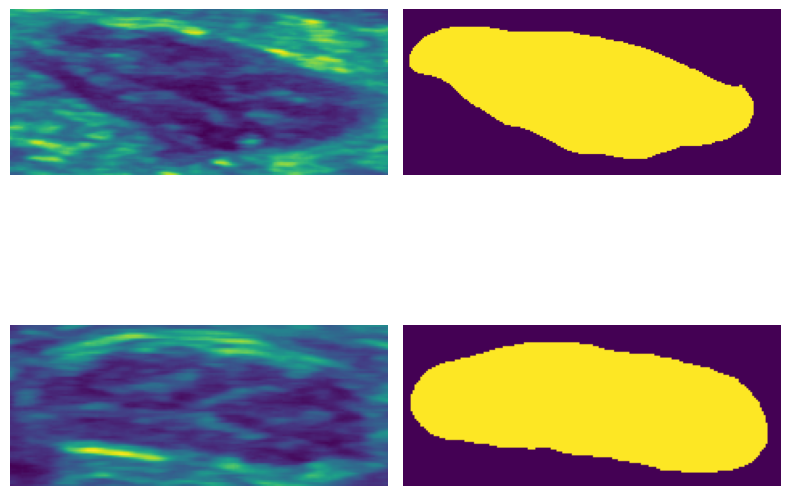

In [10]:
plot_mosaic(train_images[0], train_masks[0], val_images[0], val_masks[0])

In [13]:
class segmentationDataset(torch.utils.data.Dataset):
  """
  Dataset class for segmentation task.
  """
  def __init__(self, image_arr, seg_arr, split='train'):
    self.imgs = image_arr
    self.segs = seg_arr
    self.split = split


  def __len__(self):
    return len(self.imgs)


  def __getitem__(self, idx):
    img = torch.tensor(self.imgs[idx], dtype=torch.float32) / 255.0
    seg = torch.tensor(self.segs[idx])
    img = img.unsqueeze(0)
    seg = seg.unsqueeze(0)


    image_transform = T.Compose([
        T.Normalize(mean=[0.5], std=[0.5]),
        T.Resize((512, 512), interpolation=T.InterpolationMode.BILINEAR),
    ])

    mask_transform = T.Compose([
        T.Resize((512, 512), interpolation=T.InterpolationMode.NEAREST)  # Nearest-neighbor for masks
    ])

    train_transform = T.Compose([

        T.RandomErasing(p=0.5,scale=(0.02,0.1)),
        # T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)
    ])

    img = image_transform(img)
    seg = mask_transform(seg)

    if self.split == 'train':
        if random.random() < 0.5:
            img = F.hflip(img)
            seg = F.hflip(seg.to(torch.float32)).to(torch.uint16)
        angle = random.uniform(-10, 10)
        translate = (random.uniform(-0.1, 0.1) * img.shape[1], 
                     random.uniform(-0.1, 0.1) * img.shape[2])
        scale = random.uniform(0.9, 1.1)
        shear = random.uniform(-10, 10)

        img = F.affine(img, angle, translate, scale, shear, interpolation=T.InterpolationMode.BILINEAR)
        seg = F.affine(seg, angle, translate, scale, shear, interpolation=T.InterpolationMode.NEAREST)
        img = train_transform(img)
        # seg = train_transform(seg)
        
    return img, seg

    # return image_transform(img), mask_transform(seg)

In [14]:
train_masks[0].dtype

dtype('uint16')

In [15]:
train_dataset = segmentationDataset(train_images, train_masks)
val_dataset = segmentationDataset(val_images, val_masks, split='val')
train_dtl     = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = 32,
    shuffle     = True
)

val_dtl = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    shuffle = False
)

In [16]:
for i, data in enumerate(train_dtl):
    imgs_batch, segs_batch = data
    print(imgs_batch.shape)
    print(segs_batch.shape)
    break

torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512])


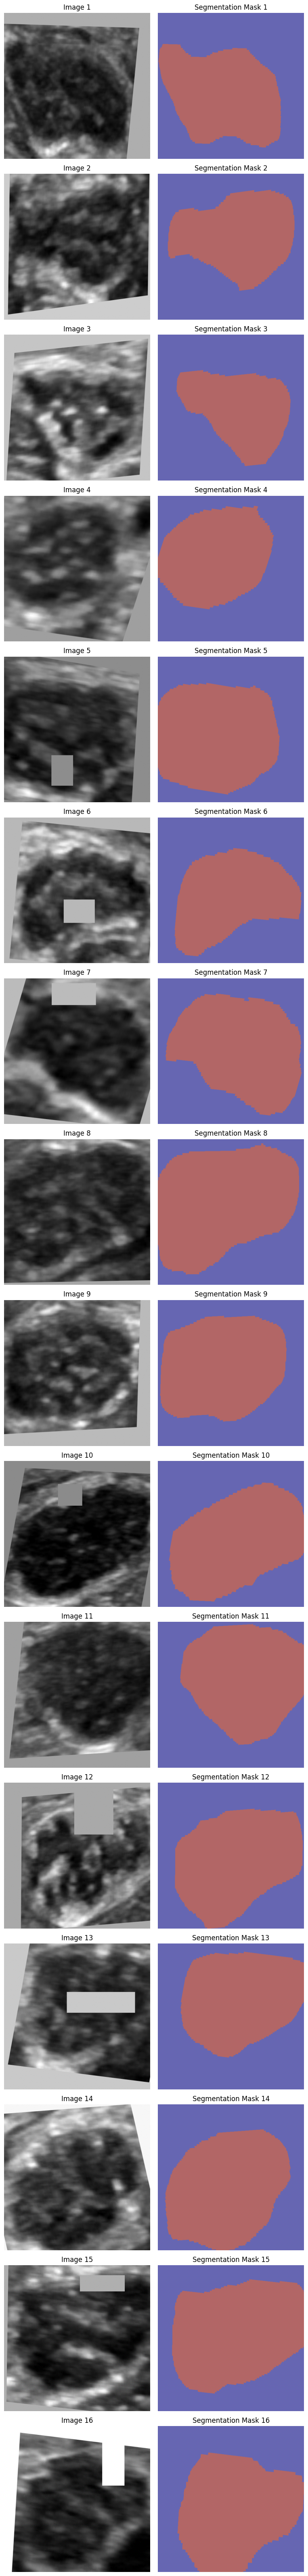

In [15]:


# Function to visualize a batch of images and segmentation masks
def visualize_batch(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))
    
    for i in range(num_samples):
        img = images[i].squeeze().cpu().numpy()  # Convert to numpy and take the first channel
        mask = masks[i].squeeze().cpu().numpy()  # Convert to numpy and take the first channel

        # Normalize image for visualization
        img = (img - img.min()) / (img.max() - img.min())

        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="jet", alpha=0.6)
        axes[i, 1].set_title(f"Segmentation Mask {i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

visualize_batch(imgs_batch, segs_batch, num_samples=16)

In [16]:
import gc
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

In [5]:
config = {
    'epochs': 40,
    'in_channels': 1,
    'dropout': 0.2,
    'decoder_attention_type': 'scse',
    'init_lr': 5e-4,
    'weight_decay': 0.05,
    'T_max': 10,
    'eta_min': 3e-5
}

In [17]:
EPOCHS = config['epochs']
unet_model = smp.Unet(encoder_name="resnet18",in_channels=1,dropout=config['in_channels'],decoder_attention_type=config['decoder_attention_type']).to(device)

criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

optimizer = torch.optim.AdamW(unet_model.parameters(),
                              lr=config['init_lr'],
                              weight_decay=config['weight_decay'])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max= config['T_max'],
        eta_min=config['eta_min'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.7, patience=2,threshold=0.01, min_lr=config['eta_min'])

scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_3511845/468507849.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [18]:
def save_model(model, optimizer, scheduler, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    return model, optimizer, scheduler, epoch

In [19]:
unet_root = 'unet_runs'
os.makedirs(unet_root, exist_ok=True)

In [20]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [21]:
def train_loop(dtl, model, criterion, optimzer, scheduler, scaler):
  model.train()
  loss_m = AverageMeter()
  batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Train')
  tps, fps, fns, tns = [], [], [], []
  for i, data in enumerate(dtl):

    imgs_batch, segs_batch = data
    imgs_batch = imgs_batch.to(device)
    segs_batch = segs_batch.to(device)

    with torch.cuda.amp.autocast():
      logits_masks = unet_model(imgs_batch)

      loss = criterion(logits_masks, segs_batch)

      prob_masks = logits_masks.sigmoid()
      pred_masks = (prob_masks > 0.5).float()

    scaler.scale(loss).backward()
    scaler.step(optimzer)
    scaler.update()

    tp, fp, fn, tn = smp.metrics.get_stats(pred_masks.long(), segs_batch.long(), mode="binary")
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)
    loss_m.update(loss.item())

    batch_bar.set_postfix(
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

    batch_bar.update() # Update tqdm bar

  scheduler.step()
  print("Train loss: {:.04f}\t Learning rate: {:.04f}".format(loss_m.avg, float(optimizer.param_groups[0]['lr'])))
  tps = torch.cat(tps)
  fps = torch.cat(fps)
  fns = torch.cat(fns)
  tns = torch.cat(tns)

  per_image_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro-imagewise")
  dataset_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro")

  print("per image IOU: {:.04f}\nper dataset IOU: {:.04f}".format(per_image_iou, dataset_iou))
  return loss, per_image_iou, dataset_iou
    

In [22]:
def val_loop(dtl, model, criterion):
  model.eval()
  loss_m = AverageMeter()
  batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Validation')
  tps, fps, fns, tns = [], [], [], []
  for i, data in enumerate(dtl):

    imgs_batch, segs_batch = data
    imgs_batch = imgs_batch.to(device)
    segs_batch = segs_batch.to(device)

    with torch.inference_mode():
      logits_masks = unet_model(imgs_batch)

      loss = criterion(logits_masks, segs_batch)

      prob_masks = logits_masks.sigmoid()
      pred_masks = (prob_masks > 0.5).float()

    tp, fp, fn, tn = smp.metrics.get_stats(pred_masks.long(), segs_batch.long(), mode="binary")
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)
    loss_m.update(loss.item())

    batch_bar.set_postfix(
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

    batch_bar.update() # Update tqdm bar

  print("Val loss: {:.04f}".format(loss_m.avg))
  tps = torch.cat(tps)
  fps = torch.cat(fps)
  fns = torch.cat(fns)
  tns = torch.cat(tns)

  per_image_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro-imagewise")
  dataset_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro")

  print("per image IOU: {:.04f}\nper dataset IOU: {:.04f}".format(per_image_iou, dataset_iou))

  return loss, per_image_iou, dataset_iou

In [23]:
gc.collect()
torch.cuda.empty_cache()

In [32]:
wandb.login(key="6e6412a1eff673cacdcda973f6e61422daaa9387")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [4]:
run = wandb.init(
    name    = 'cropped images w resnet18 backbone  lower lr', ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    #id     = "y28t31uz", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "unet", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

NameError: name 'config' is not defined

In [27]:
best_iou = 0
best_epoch = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1} / {EPOCHS}')
    train_loss, train_per_image_iou, train_dataset_iou = train_loop(train_dtl, unet_model, criterion, optimizer, scheduler, scaler)
    val_loss, val_per_image_iou, val_dataset_iou =val_loop(val_dtl, unet_model, criterion)
    # wandb.log({'train_loss': train_loss, 'train_per_image_iou': train_per_image_iou, 'train_dataset_iou': train_dataset_iou,
               # 'val_loss': val_loss, 'val_per_image_iou': val_per_image_iou, 'val_dataset_iou': val_dataset_iou, 'lr': scheduler.get_last_lr()[0]})
    # scheduler.step(val_loss)
    if val_dataset_iou > best_iou:
        best_iou = val_dataset_iou
        best_epoch = epoch

    # save_model(unet_model, optimizer, scheduler, epoch, os.path.join(unet_root, f"epoch_{epoch+1}.pth"))
    torch.save(unet_model.state_dict(), os.path.join(unet_root, f"epoch_{epoch+1}.pth"))

Epoch 1 / 40


/tmp/ipykernel_3511845/3753527618.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.                   | 0/3 [00:00<?, ?it/s]
  with torch.cuda.amp.autocast():
                                                                                                                                                                                                            

Train loss: 0.0561	 Learning rate: 0.0005
per image IOU: 0.9160
per dataset IOU: 0.9180


Val loss: 0.0948
per image IOU: 0.8478
per dataset IOU: 0.8452
Epoch 2 / 40


Train loss: 0.0567	 Learning rate: 0.0005
per image IOU: 0.9116
per dataset IOU: 0.9146


Val loss: 0.0982
per image IOU: 0.8394
per dataset IOU: 0.8377
Epoch 3 / 40


Train loss: 0.0602	 Learning rate: 0.0004
per image IOU: 0.9036
per dataset IOU: 0.9056


Val loss: 0.0953
per image IOU: 0.8453
per dataset IOU: 0.8425
Epoch 4 / 40


Train loss: 0.0579	 Learning rate: 0.0003
per image IOU: 0.9094
per dataset IOU: 0.9106


Val loss: 0.1101
per image IOU: 0.8180
per dataset IOU: 0.8152
Epoch 5 / 40


Train loss: 0.0569	 Learning rate: 0.0003
per image IOU: 0.9105
per dataset IOU: 0.9126


Val loss: 0.1110
per image IOU: 0.8169
per dataset IOU: 0.8125
Epoch 6 / 40


Train loss: 0.0523	 Learning rate: 0.0002
per image IOU: 0.9177
per dataset IOU: 0.9184


Val loss: 0.1038
per image IOU: 0.8302
per dataset IOU: 0.8248
Epoch 7 / 40


Train loss: 0.0509	 Learning rate: 0.0001
per image IOU: 0.9183
per dataset IOU: 0.9196


Val loss: 0.0974
per image IOU: 0.8402
per dataset IOU: 0.8359
Epoch 8 / 40


Train loss: 0.0471	 Learning rate: 0.0001
per image IOU: 0.9242
per dataset IOU: 0.9260


Val loss: 0.0931
per image IOU: 0.8461
per dataset IOU: 0.8428
Epoch 9 / 40


Train loss: 0.0466	 Learning rate: 0.0000
per image IOU: 0.9258
per dataset IOU: 0.9274


Val loss: 0.0918
per image IOU: 0.8474
per dataset IOU: 0.8445
Epoch 10 / 40


Train loss: 0.0457	 Learning rate: 0.0000
per image IOU: 0.9258
per dataset IOU: 0.9282


Val loss: 0.0905
per image IOU: 0.8492
per dataset IOU: 0.8464
Epoch 11 / 40


Train loss: 0.0436	 Learning rate: 0.0000
per image IOU: 0.9308
per dataset IOU: 0.9323


Val loss: 0.0897
per image IOU: 0.8506
per dataset IOU: 0.8477
Epoch 12 / 40


Train loss: 0.0438	 Learning rate: 0.0001
per image IOU: 0.9303
per dataset IOU: 0.9312


Val loss: 0.0877
per image IOU: 0.8543
per dataset IOU: 0.8514
Epoch 13 / 40


Train loss: 0.0430	 Learning rate: 0.0001
per image IOU: 0.9316
per dataset IOU: 0.9331


Val loss: 0.0855
per image IOU: 0.8585
per dataset IOU: 0.8555
Epoch 14 / 40


Train loss: 0.0422	 Learning rate: 0.0002
per image IOU: 0.9362
per dataset IOU: 0.9372


Val loss: 0.0852
per image IOU: 0.8592
per dataset IOU: 0.8560
Epoch 15 / 40


Train loss: 0.0426	 Learning rate: 0.0003
per image IOU: 0.9334
per dataset IOU: 0.9343


Val loss: 0.0863
per image IOU: 0.8573
per dataset IOU: 0.8540
Epoch 16 / 40


Train loss: 0.0385	 Learning rate: 0.0003
per image IOU: 0.9391
per dataset IOU: 0.9410


Val loss: 0.0854
per image IOU: 0.8580
per dataset IOU: 0.8553
Epoch 17 / 40


Train loss: 0.0429	 Learning rate: 0.0004
per image IOU: 0.9311
per dataset IOU: 0.9318


Val loss: 0.0831
per image IOU: 0.8622
per dataset IOU: 0.8593
Epoch 18 / 40


Train loss: 0.0409	 Learning rate: 0.0005
per image IOU: 0.9329
per dataset IOU: 0.9357


Val loss: 0.0845
per image IOU: 0.8594
per dataset IOU: 0.8565
Epoch 19 / 40


Train loss: 0.0427	 Learning rate: 0.0005
per image IOU: 0.9323
per dataset IOU: 0.9330


Val loss: 0.0855
per image IOU: 0.8567
per dataset IOU: 0.8539
Epoch 20 / 40


Train loss: 0.0426	 Learning rate: 0.0005
per image IOU: 0.9292
per dataset IOU: 0.9305


Val loss: 0.0886
per image IOU: 0.8512
per dataset IOU: 0.8484
Epoch 21 / 40


Train loss: 0.0448	 Learning rate: 0.0005
per image IOU: 0.9257
per dataset IOU: 0.9268


Val loss: 0.0959
per image IOU: 0.8369
per dataset IOU: 0.8342
Epoch 22 / 40


Train loss: 0.0451	 Learning rate: 0.0005
per image IOU: 0.9234
per dataset IOU: 0.9251


Val loss: 0.0861
per image IOU: 0.8528
per dataset IOU: 0.8506
Epoch 23 / 40


Train loss: 0.0429	 Learning rate: 0.0004
per image IOU: 0.9267
per dataset IOU: 0.9293


Val loss: 0.0906
per image IOU: 0.8450
per dataset IOU: 0.8421
Epoch 24 / 40


Train loss: 0.0455	 Learning rate: 0.0003
per image IOU: 0.9217
per dataset IOU: 0.9243


Val loss: 0.0841
per image IOU: 0.8557
per dataset IOU: 0.8533
Epoch 25 / 40


Train loss: 0.0419	 Learning rate: 0.0003
per image IOU: 0.9262
per dataset IOU: 0.9289


Val loss: 0.0784
per image IOU: 0.8645
per dataset IOU: 0.8626
Epoch 26 / 40


Train loss: 0.0408	 Learning rate: 0.0002
per image IOU: 0.9299
per dataset IOU: 0.9311


Val loss: 0.0806
per image IOU: 0.8610
per dataset IOU: 0.8585
Epoch 27 / 40


Train loss: 0.0420	 Learning rate: 0.0001
per image IOU: 0.9276
per dataset IOU: 0.9293


Val loss: 0.0825
per image IOU: 0.8576
per dataset IOU: 0.8549
Epoch 28 / 40


Train loss: 0.0384	 Learning rate: 0.0001
per image IOU: 0.9341
per dataset IOU: 0.9368


Val loss: 0.0838
per image IOU: 0.8551
per dataset IOU: 0.8526
Epoch 29 / 40


Train loss: 0.0371	 Learning rate: 0.0000
per image IOU: 0.9370
per dataset IOU: 0.9390


Val loss: 0.0867
per image IOU: 0.8503
per dataset IOU: 0.8476
Epoch 30 / 40


Train loss: 0.0351	 Learning rate: 0.0000
per image IOU: 0.9388
per dataset IOU: 0.9412


Val loss: 0.0866
per image IOU: 0.8505
per dataset IOU: 0.8478
Epoch 31 / 40


Train loss: 0.0347	 Learning rate: 0.0000
per image IOU: 0.9404
per dataset IOU: 0.9419


Val loss: 0.0858
per image IOU: 0.8519
per dataset IOU: 0.8492
Epoch 32 / 40


Train loss: 0.0363	 Learning rate: 0.0001
per image IOU: 0.9381
per dataset IOU: 0.9406


Val loss: 0.0852
per image IOU: 0.8527
per dataset IOU: 0.8502
Epoch 33 / 40


Train loss: 0.0385	 Learning rate: 0.0001
per image IOU: 0.9375
per dataset IOU: 0.9391


Val loss: 0.0868
per image IOU: 0.8499
per dataset IOU: 0.8474
Epoch 34 / 40


Train loss: 0.0331	 Learning rate: 0.0002
per image IOU: 0.9443
per dataset IOU: 0.9460


Val loss: 0.0875
per image IOU: 0.8487
per dataset IOU: 0.8459
Epoch 35 / 40


Train loss: 0.0341	 Learning rate: 0.0003
per image IOU: 0.9433
per dataset IOU: 0.9444


Val loss: 0.0863
per image IOU: 0.8502
per dataset IOU: 0.8481
Epoch 36 / 40


Train loss: 0.0324	 Learning rate: 0.0003
per image IOU: 0.9453
per dataset IOU: 0.9464


Val loss: 0.0817
per image IOU: 0.8580
per dataset IOU: 0.8561
Epoch 37 / 40


Train loss: 0.0331	 Learning rate: 0.0004
per image IOU: 0.9433
per dataset IOU: 0.9445


Val loss: 0.0870
per image IOU: 0.8499
per dataset IOU: 0.8465
Epoch 38 / 40


Train loss: 0.0329	 Learning rate: 0.0005
per image IOU: 0.9445
per dataset IOU: 0.9454


Val loss: 0.0871
per image IOU: 0.8495
per dataset IOU: 0.8463
Epoch 39 / 40


Train loss: 0.0337	 Learning rate: 0.0005
per image IOU: 0.9426
per dataset IOU: 0.9431


Val loss: 0.0861
per image IOU: 0.8503
per dataset IOU: 0.8476
Epoch 40 / 40


Train loss: 0.0357	 Learning rate: 0.0005
per image IOU: 0.9367
per dataset IOU: 0.9380


Val loss: 0.0861
per image IOU: 0.8510
per dataset IOU: 0.8474


In [70]:
run.finish()

In [28]:
print(best_iou, best_epoch)

tensor(0.8626, device='cuda:0') 24


In [29]:
sum(p.sum().item() for p in unet_model.parameters())

-12171.1942758339

In [72]:
unet_model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [17]:
for i, data in enumerate(val_dtl):
    imgs_batch, segs_batch = data
    print(imgs_batch.shape)
    print(segs_batch.shape)
    break

torch.Size([29, 1, 512, 512])
torch.Size([29, 1, 512, 512])


In [18]:
result = unet_model(imgs_batch.to(device))

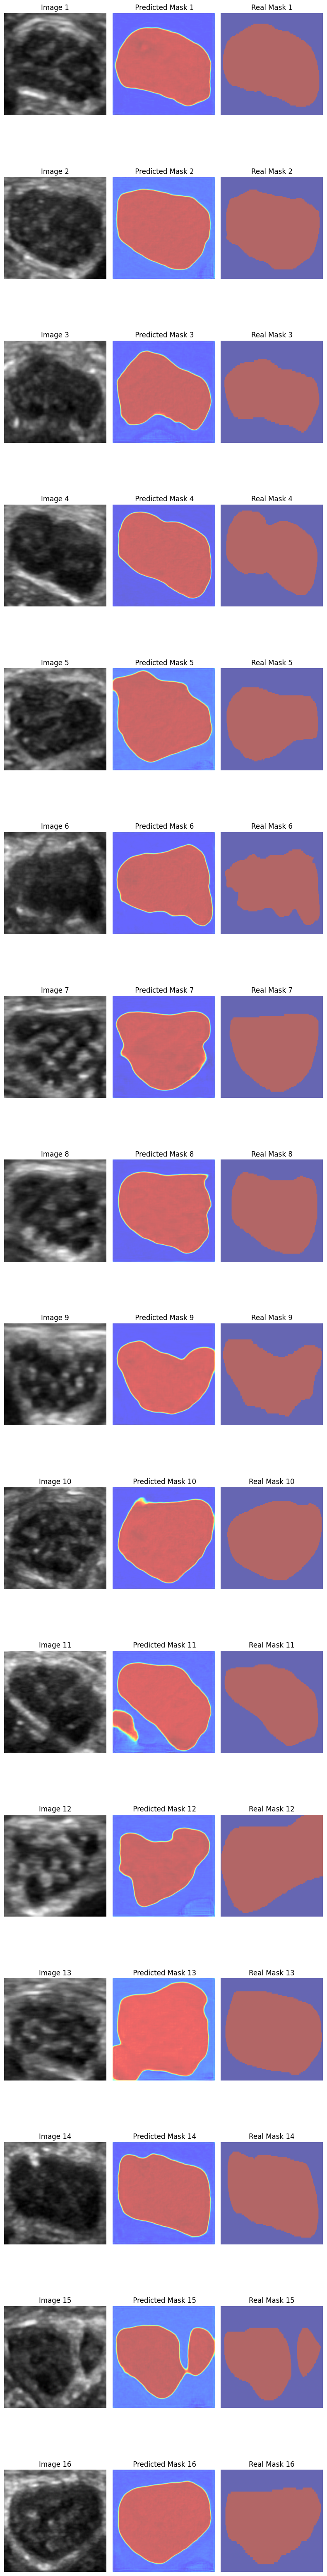

In [19]:


# Function to visualize a batch of images and segmentation masks
def visualize_batch(images, masks, masks2, num_samples=4):
    fig, axes = plt.subplots(num_samples, 3, figsize=(8, num_samples * 4))
    
    for i in range(num_samples):
        img = images[i].squeeze().cpu().numpy()  # Convert to numpy and take the first channel
        mask = masks[i].squeeze().cpu().detach().numpy()  # Convert to numpy and take the first channel
        mask2 = masks2[i].squeeze().cpu().numpy()

        # Normalize image for visualization
        img = (img - img.min()) / (img.max() - img.min())

        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="jet", alpha=0.6)
        axes[i, 1].set_title(f" Predicted Mask {i+1}")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(mask2, cmap="jet", alpha=0.6)
        axes[i, 2].set_title(f"Real Mask {i+1}")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

visualize_batch(imgs_batch, result, segs_batch, num_samples=16)

In [30]:
imgs_batch.device

device(type='cpu')

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

unet_model = smp.Unet(encoder_name="resnet18",in_channels=1,dropout=config['in_channels'],decoder_attention_type=config['decoder_attention_type']).to(device)

# unet_model, _, _, _ = load_model(unet_model, optimizer=None, scheduler=None, path=f'unet_runs/epoch_40.pth')
checkpoint = torch.load('unet_runs/epoch_40.pth', map_location="cuda")
unet_model.load_state_dict(checkpoint, strict=True)
unet_model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

  0%|                              | 0/87 [00:00<?, ?it/s]


0: 480x1120 1 ulnar, 7.5ms
Speed: 8.5ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 1120)


  0%|                              | 0/87 [00:00<?, ?it/s]


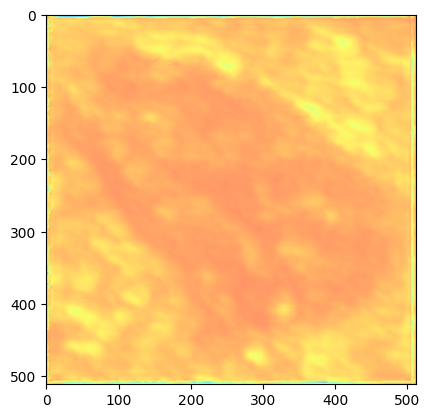

In [37]:
train_images = []
train_labels = []
val_images = []
val_labels = []


image_transform = T.Compose([
    T.Resize((512, 512), interpolation=T.InterpolationMode.BILINEAR),  # ✅ Resize first
    T.Normalize(mean=[0.5], std=[0.5]),  # ✅ Normalize after
])
# def fill_arr(img_dir, img_bucket, mask_bucket):
for jpg_name in tqdm(os.listdir(image_train_dir)): 
    entry_name = jpg_name.split('.')[0]
    img_filename = entry_name + '.dcm'
    # mask_filename = jpg_name.split('.')[0] + '.nii.gz'
    
    img = load_dicom(os.path.join(dicom_dir, img_filename))
    # mask = load_mask(os.path.join(anno_dir, mask_filename))
   
    result = model(img, save=False)
    box = result[0].boxes
    
    if len(box.xyxy.tolist())== 0:
        continue
    x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])
    img_slice = img[y1:y2, x1:x2, 0]
    

    img_tensor = torch.from_numpy(img_slice).float()  # Convert to float tensor
    

    # Add batch and channel dimensions if needed (for model input)
    img_tensor = img_tensor.unsqueeze(0)  # Shape: (1, 1, 512, 512)

    
    # Send to device
    
    img_tensor = image_transform(img_tensor)
    img_tensor = img_tensor.to(device)

    img_resized = img_tensor.squeeze().cpu().detach().numpy()
    with torch.no_grad():
        # with autocast():
            mask_gpu = unet_model(img_tensor.unsqueeze(0))
    mask = mask_gpu.squeeze().cpu().detach().numpy()
    # mask = (mask > 0.5).astype(np.uint8)

    img_2channel = np.stack((img_resized, mask), axis=2)
    # plt.imshow(img_2channel[:,:,0], cmap="gray")
    plt.imshow(img_2channel[:,:,1], cmap="jet", alpha=0.6)
    break
    
        # img_bucket.append(img[y1:y2, x1:x2, 0])
        # mask_bucket.append(mask[y1:y2, x1:x2])
        
        

# fill_arr(image_train_dir, train_images, train_labels)
# fill_arr(image_val_dir, val_images, val_labels)


===== SHAPE COMPARISON =====
Inference img_tensor shape: torch.Size([512, 512])
Validation batch image shape: torch.Size([1, 512, 512])

===== DTYPE COMPARISON =====
Inference img_tensor dtype: torch.float32
Validation batch image dtype: torch.float32

===== MIN/MAX VALUE COMPARISON =====
Inference img_tensor min/max: 31.0, 331.7367858886719
Validation batch image min/max: -0.8647365570068359, 0.733326256275177

===== MEAN/STANDARD DEVIATION COMPARISON =====
Inference img_tensor mean/std: 134.00982666015625, 57.57035827636719
Validation batch image mean/std: -0.41646742820739746, 0.26341989636421204

===== PIXEL-WISE DIFFERENCE CHECK =====
Mean absolute difference: 134.42628479003906
Max absolute difference: 331.9737243652344


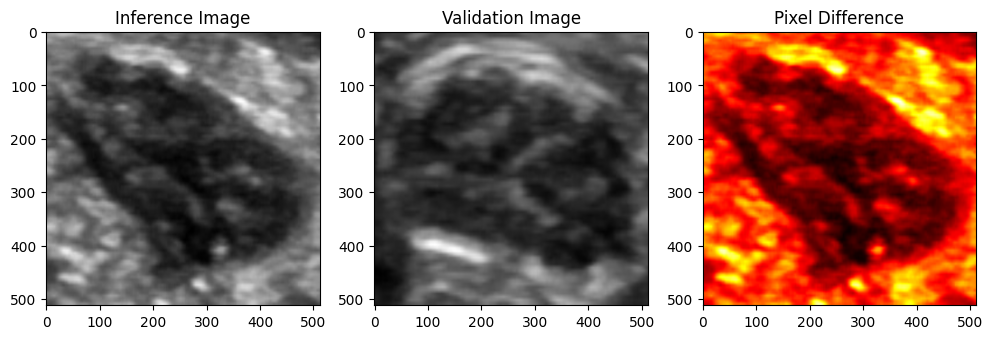

In [38]:
# Take 1 image from validation batch
batch_sample = imgs_batch[0].to(device)  # Assuming imgs_batch shape is (29, 1, 512, 512)

# Ensure img_tensor is also (1, 512, 512)
img_tensor = img_tensor.squeeze(0)  # Remove batch dim if necessary

print("\n===== SHAPE COMPARISON =====")
print(f"Inference img_tensor shape: {img_tensor.shape}")
print(f"Validation batch image shape: {batch_sample.shape}")

print("\n===== DTYPE COMPARISON =====")
print(f"Inference img_tensor dtype: {img_tensor.dtype}")
print(f"Validation batch image dtype: {batch_sample.dtype}")

print("\n===== MIN/MAX VALUE COMPARISON =====")
print(f"Inference img_tensor min/max: {img_tensor.min().item()}, {img_tensor.max().item()}")
print(f"Validation batch image min/max: {batch_sample.min().item()}, {batch_sample.max().item()}")

print("\n===== MEAN/STANDARD DEVIATION COMPARISON =====")
print(f"Inference img_tensor mean/std: {img_tensor.mean().item()}, {img_tensor.std().item()}")
print(f"Validation batch image mean/std: {batch_sample.mean().item()}, {batch_sample.std().item()}")

print("\n===== PIXEL-WISE DIFFERENCE CHECK =====")
diff = torch.abs(img_tensor - batch_sample)
print(f"Mean absolute difference: {diff.mean().item()}")
print(f"Max absolute difference: {diff.max().item()}")

# Visualize difference
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_tensor.cpu().numpy().squeeze(), cmap="gray")
plt.title("Inference Image")

plt.subplot(1, 3, 2)
plt.imshow(batch_sample.cpu().numpy().squeeze(), cmap="gray")
plt.title("Validation Image")

plt.subplot(1, 3, 3)
plt.imshow(diff.cpu().numpy().squeeze(), cmap="hot")
plt.title("Pixel Difference")

plt.show()
